In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout, BatchNormalization
from keras import regularizers
import numpy as np 
import pandas as pd 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler #outlier'ı daha iyi handle etmek icin kullanılıyor.
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

2023-02-04 12:44:07.183282: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# data read:
cc_data_original = pd.read_csv("card_transdata.csv") 
cc_data = cc_data_original.copy()
cc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [3]:
# train test split.
X = cc_data.iloc[:,:-1]
y = cc_data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)
validation_split = (X_val, y_val)

In [4]:
# to see whether dataset balancer or unbalanced.
y_train.value_counts()

0.0    638782
1.0     61218
Name: fraud, dtype: int64

In [5]:
count_no_fraud = len(cc_data[cc_data['fraud']==0])
count_fraud = len(cc_data[cc_data['fraud']==1])
pct_of_no_fraud = count_no_fraud/(count_no_fraud+count_fraud)
print("Percentage of no fraud is", pct_of_no_fraud*100)
pct_of_fraud = count_fraud/(count_no_fraud+count_fraud)
print("Percentage of fraud is", pct_of_fraud*100)

Percentage of no fraud is 91.2597
Percentage of fraud is 8.7403


In [6]:
X_train.columns

Index(['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order'],
      dtype='object')

In [7]:
X_train.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
count,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000
mean,26.650287,5.047713,1.821840,0.881736,0.349941,0.100609,0.650547
std,64.895641,26.764043,2.804892,0.322921,0.476952,0.300810,0.476798
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000
25%,3.881693,0.296986,0.475043,1.000000,0.000000,0.000000,0.000000
50%,9.976658,1.000434,0.996097,1.000000,0.000000,0.000000,1.000000
75%,25.775617,3.350729,2.094424,1.000000,1.000000,0.000000,1.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000


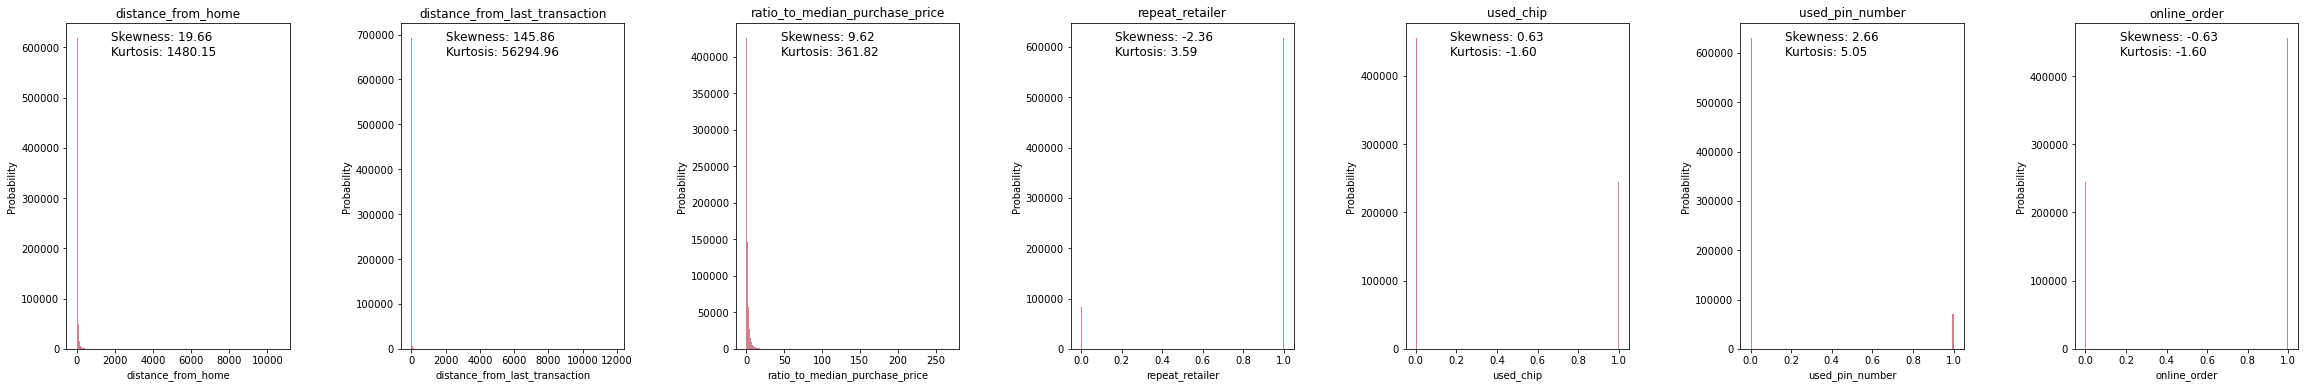

In [8]:
# Variable Distribution
#pre-process:
train_to_scale = X_train[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']]
test_to_scale = X_test[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']]

#plot:
fig, axs = plt.subplots(1, 7, figsize=(40, 6))
fig.subplots_adjust(wspace=0.5)
axs = axs.ravel()
cmap = sns.color_palette("RdBu", as_cmap=True)
skewness = train_to_scale.skew()
kurtosis = train_to_scale.kurtosis()
for i, column in enumerate(train_to_scale.columns):
    axs[i].set_title(column)
    axs[i].hist(train_to_scale[column], bins=200, alpha=0.5,color  = plt.cm.RdYlGn(1))
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Probability')
    axs[i].annotate(text='Skewness: {:.2f}\nKurtosis: {:.2f}'.format(skewness[column], kurtosis[column]), xy=(0.2, 0.9), xycoords='axes fraction', fontsize=12)
plt.show()


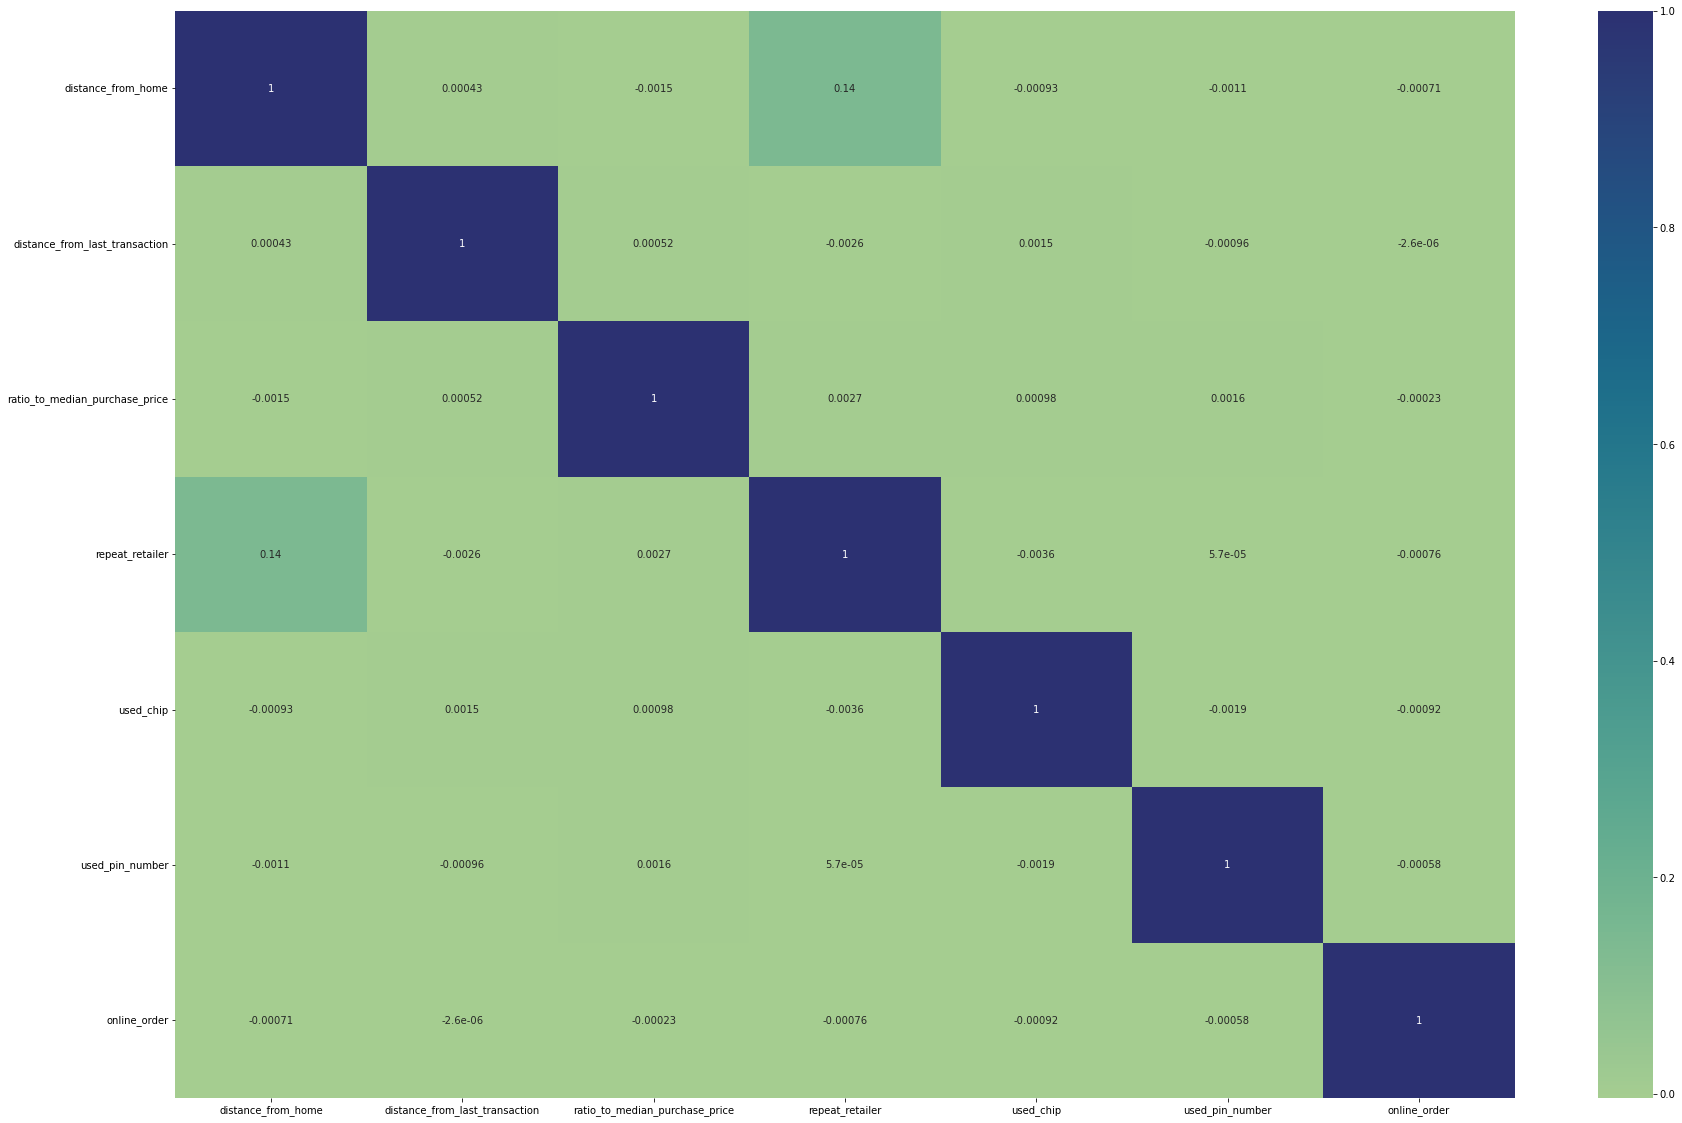

In [9]:
fig, ax = plt.subplots(figsize=(30,20))  
sns.heatmap(train_to_scale.corr(),annot=True,cmap = "crest")
plt.show()

#### COR MATRIX WITH LABEL COLUMN
fig, ax = plt.subplots(figsize=(30,20)) 
except 
corr_matrix = sns.heatmap(cc_data.corr(),annot=True,cmap = "crest")
corr_matrix["fraud"]

In [10]:
# KURTOSIS > 3 ( THE DATA HIGHLY SKEWED) IS A PROBLEM SO WE APPLY TRANSFORMATION? (WHY??)

from sklearn.preprocessing import power_transform

kurtosis3 = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']

#EVEN OTHERS' KURTOSIS > 3 WE DON'T APPLY ANYTHING SINCE IT'S A BINARY DECISION.

for i in kurtosis3 : 
    train_to_scale[[i]]= (power_transform(train_to_scale[[i]],method = 'yeo-johnson'))

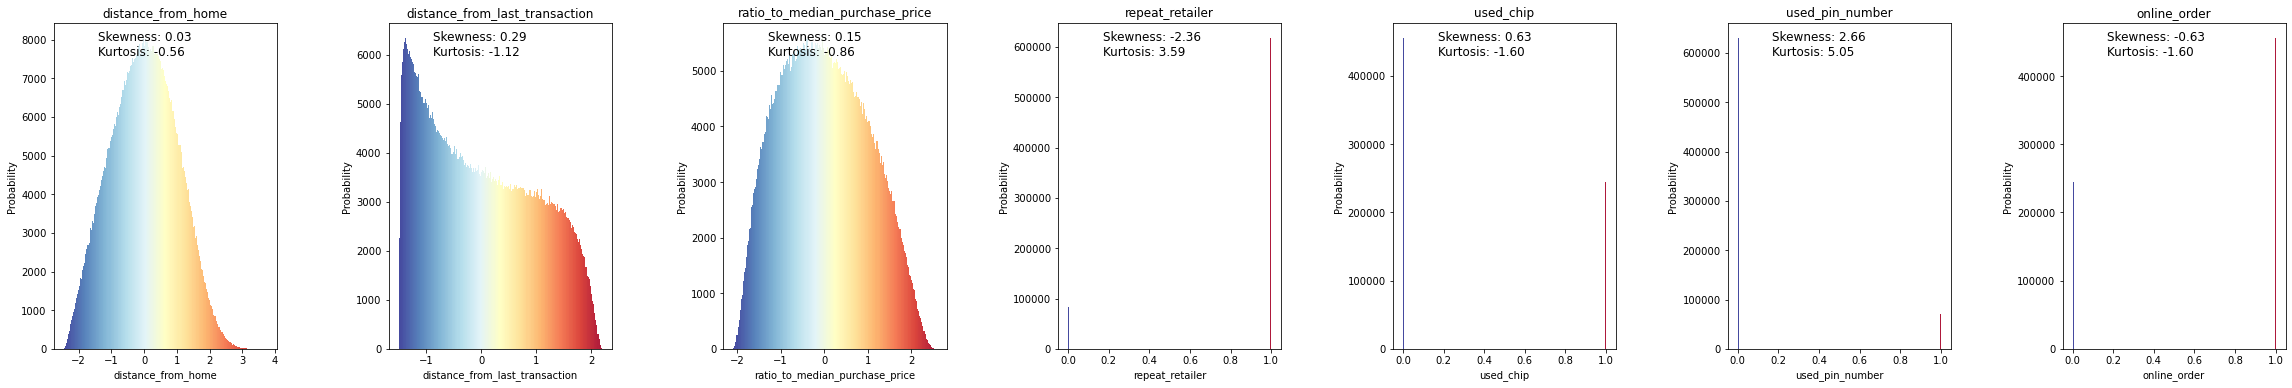

In [11]:
fig, axs = plt.subplots(1, 7, figsize=(40, 6))
fig.subplots_adjust(wspace=0.5)
axs = axs.ravel()
cm = plt.cm.get_cmap('RdYlBu_r')
skewness = train_to_scale.skew()
kurtosis = train_to_scale.kurtosis()
for i, column in enumerate(train_to_scale.columns):
    
    axs[i].set_title(column)
    n, bins, patches  = axs[i].hist(train_to_scale[column], bins=200, alpha=0.9)
    axs[i].annotate(text='Skewness: {:.2f}\nKurtosis: {:.2f}'.format(skewness[column], kurtosis[column]), xy=(0.2, 0.9), xycoords='axes fraction', fontsize=12)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # scale values to interval [0,1]
    col = bin_centers - min(bin_centers)
    col /= max(col)

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))
        axs[i].set_xlabel(column)
        axs[i].set_ylabel('Probability')
    
plt.show()

In [12]:
scaler = RobustScaler()

scaled_train = pd.DataFrame(scaler.fit_transform(train_to_scale),columns = train_to_scale.columns)
scaled_test = pd.DataFrame(scaler.transform(test_to_scale),columns = test_to_scale.columns)
X_train = scaled_train
X_test = scaled_test

In [13]:
model = Sequential()

# Add layers to the model
model.add(Dense(8116, input_dim=7, activation='relu')) #input layer with 64 neurons
model.add(Dropout(0.5))
model.add(Dense(2048,activation= 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(8,activation= 'relu'))
model.add(Dense(1, activation='sigmoid')) #output layer with 1 neuron 
model.compile(loss=['binary_crossentropy'], optimizer= tf.keras.optimizers.Nadam(4e-6),metrics = [tf.keras.metrics.AUC(curve='ROC')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8116)              64928     
                                                                 
 dropout (Dropout)           (None, 8116)              0         


2023-02-04 12:44:25.927562: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


                                                                 
 dense_1 (Dense)             (None, 2048)              16623616  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               262400    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (

In [14]:
model.fit(X_train,y_train,validation_split = 0.26,batch_size = 4096, epochs = 25)#,callbacks=[callbacks])

Epoch 1/25
127/127 [==============================] - 370s 3s/step - loss: 0.5786 - auc: 0.4759 - val_loss: 0.4084 - val_auc: 0.4635
Epoch 2/25
127/127 [==============================] - 388s 3s/step - loss: 0.3312 - auc: 0.5816 - val_loss: 0.2752 - val_auc: 0.7353
Epoch 3/25
127/127 [==============================] - 444s 3s/step - loss: 0.2536 - auc: 0.7967 - val_loss: 0.2249 - val_auc: 0.8544
Epoch 4/25
127/127 [==============================] - 501s 4s/step - loss: 0.2163 - auc: 0.8701 - val_loss: 0.1967 - val_auc: 0.9022
Epoch 5/25
127/127 [==============================] - 509s 4s/step - loss: 0.1904 - auc: 0.9086 - val_loss: 0.1724 - val_auc: 0.9312
Epoch 6/25
127/127 [==============================] - 784s 6s/step - loss: 0.1666 - auc: 0.9337 - val_loss: 0.1468 - val_auc: 0.9485
Epoch 7/25
127/127 [==============================] - 747s 6s/step - loss: 0.1435 - auc: 0.9501 - val_loss: 0.1226 - val_auc: 0.9602
Epoch 8/25
127/127 [==============================] - 539s 4s/step - 